In [54]:
import torch
import torch.nn as nn

In [55]:
architecture_config = [
    (7, 64, 2, 3), #kernal size, filters as output, stride, padding(calculated by hand)
    "M", # maxpool
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    #List: tuples and then last integer represents number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

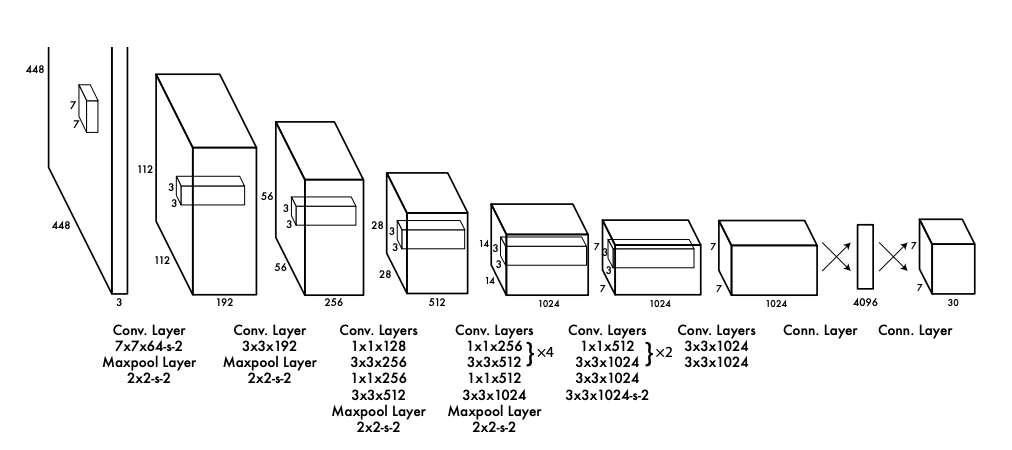

In [56]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
    
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))



In [57]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels
        
        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                    in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3]
                )
                ]
                in_channels = x[1]
            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            elif type(x) == list:
                # Tuple, Tuple, int
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for i in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]

                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]

                    in_channels = conv2[1]
                    
        return nn.Sequential(*layers)
    

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            # nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
            #Need to do a reshape later on because it is a linear layer right now
            # Into (S, S, 30) where C + B * 5 = 30
        )


In [58]:
def test(S=7, B=2, C=20):
    model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
    x = torch.randn((2, 3, 448, 448))
    print(model(x).shape)

In [59]:
test()

torch.Size([2, 1470])
